# SF Salinity KOs, LASSO CV to predict methane v.11 -- plot figs vers 2021

- v.10 working functions, consistent, cleans v0.9 cruft
- v0.9 Finds / fixes inconsistencies among versions, comments out old code
- v0.8 uses / reorgs new Lasso functions
- v0.7 makes new functions for Lasso
- v0.6 cleans guild features, data still below
- v0.5 redoes import functions, v0.4 was last but data issues, last figs from v0.2 UMX..

- note this vers. also uses cdips2017 py version, others may be missing SKlearn components like Robust Scaler, scorers, etc.

### 0) Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib
import scipy

import warnings
warnings.filterwarnings('ignore')

import sklearn as sk

%matplotlib inline
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
sns.set_style("white")
sns.set_style("ticks")

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [3]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics

In [4]:
from sklearn.linear_model import RandomizedLasso

ImportError: cannot import name 'RandomizedLasso' from 'sklearn.linear_model' (/Users/cliftonbdemesquita/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/__init__.py)

# 1) Import data: Environment, Genes, Ontology

- Env_chem, gene_ontol_colors, Gene_counts [used]

- also, Gene_abund [all genes, not restricted to ontology genes as in counts]

## a) Import & clean Environment data:

- Env_chem

- creates DELTA ONLY subset unless commented out

#### i) Import metadata (chemistry)

In [5]:
# Import and clean environment data
# Note for v0.5 input data is LINEAR (fix3, note fix 3.5 is missing some of the below vars)
Sal_meta = pd.read_csv('../data/meta/SF_sal_meta_FIX3.txt', sep='\t', index_col=0)
Sal_meta['Salinity'] =  Sal_meta['Salinity.x']                                 #Sal_meta.columns # Sal_meta.head(10) # Sal_meta.EWcoastGroup.unique()

#### ii) Make environment subsets
- for oligo / Delta sites only analysis, or comment out below

In [6]:
###  LOW Salinity sites                                       # Sal_meta.SALTgroup.unique()
FW = Sal_meta[Sal_meta['SALTgroup'].str.contains('FW')]         # Get subsets 
Oligo = Sal_meta[Sal_meta['SALTgroup'].str.contains('Oligo')]
# Meso = Sal_meta[Sal_meta['SALTgroup'].str.contains('Meso')]

# DELTA ONLY sites
Oligo_FW = (FW, Oligo)                                           # Make set list 
Oligo_FW_sites = pd.concat(Oligo_FW)                             # Concat SET
Oligo_FW_sites.sort_values(by = 'Index', axis=0, inplace=True)   # Sort on Site index        

### REF SITES ONLY 
Ref_sites_ONLY = Sal_meta[Sal_meta['EWcoastGroup'].str.contains('SF_Ref')]

In [7]:
#Oligo_FW_sites['Sample']

In [8]:
#### Select OLIGO only sites at own risk !!
# can just comment this line out:
#Sal_meta=Oligo_FW_sites

#### iii) Select Env. Chem variables
- ignores some features like soil metals
- sets NA to 0.1 to fill missing porewater data (below detection)

In [9]:
## CUT Down Env. Data
env_chem_List = ['Salinity', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',                       # with log DATA, delete 'logCH4' now is logged, except for LIN vars
       'CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d', 'pH',            # Drop cations, corr w. Sal: 'Ca_pw', 'Sr_pw','Mg_pw', 'Na_pw', 'K_pw', 'Al_pw', 'Si_pw', 'Br_pw', 'F_pw', 'logCH4']
       'Cl', 'SO4', 'Corg_LOI', 'C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',               # Drop soil metals for now, half NA: 'Fe', 'Mn', 'Cu', 'Zn']
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'C_g_m2', 'N_g_m2', 'P_g_m2',               # Drop redundant cols for PW: 'Salinity.x.1', 'CO2_mg_m2_h.1','CH4_ug_m2_h.1'
       'DOC_mg_L','Cl_pw', 'SO4_pw', 'NO2_pw', 'NO3_pw','NH3_pw',                         # Much more DELETED here, see earlier versions... # Sal_meta.columns # Env_chem.head()  
       'PO4_pw', 'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw'] 
              
# ABSTRACT Env_chem
Env_chem = Sal_meta[env_chem_List]  # Get columns
Env_chem.fillna(0.1, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals

## ReINDEX Env. chem, MUST BE by Sample
Sample = Sal_meta['Sample'] 
Env_chem = Env_chem.set_index(Sample,0)  

In [10]:
Env_chem.index.name

'Sample'

In [11]:
del Env_chem.index.name 

AttributeError: can't delete attribute

In [12]:
# Drop bad porewater data from above
drop_vars = ['NO2_pw', 'NO3_pw','NH3_pw', 'PO4_pw']              # inorg N samps ruined, PO4 mostly 0/NA due to IC method
Env_chem.drop(drop_vars, axis = 1, inplace=True)

In [13]:
# Drop more non-sense variables 

#### iv) log transform data
- includes log n+1 for vars with negative values (like CH4 flux!)

In [14]:
# Log10 transform data set
Env_chem_log = np.log10(Env_chem)
# Env_chem_log.head()

In [15]:
# Get log(n+1 data) for select vars
log_n1_cols = ['CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d']
#log_n1_data = np.log(Env_chem[log_n1_cols] + 1)
# Cliff update - log10 instead of log (natural log!!)
log_n1_data = np.log10(Env_chem[log_n1_cols] + 1)
# log_n1_data.head()

In [16]:
# Replace log N + 1 data
Env_chem_log['CH4_ug_m2_h'] =  log_n1_data['CH4_ug_m2_h']
Env_chem_log['CH4_CO2'] =  log_n1_data['CH4_CO2']
Env_chem_log['CH4_soilC_ug_g_d'] =  log_n1_data['CH4_soilC_ug_g_d']

In [17]:
# Fill NA in porewater
#Env_chem.fillna(0.1, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals

In [18]:
#Env_chem_log.head()

In [19]:
np.log(1000)

6.907755278982137

#### i) add back some vars as linear
- might not be worth it, ignore later...

In [20]:
# Get linear data
#linear_vars = ['CO2_mg_m2_h', 'CH4_ug_m2_h', 'Salinity']
#linear_data = Env_chem[linear_vars]
#linear_data.columns = ['Salinity_lin', 'CH4_m2_lin', 'CO2_m2_lin']

# add linear to log df
#Env_chem_log = pd.concat([Env_chem_log, linear_data], axis =1)

# rename to Env_chem for downstream code
Env_chem = Env_chem_log

In [21]:
# drop first row of data (Sandmound_cattail is not a "real" sample)
#Env_chem.drop(["Sandmound_CattailA_D1"], axis=0, inplace = True)

In [22]:
#Env_chem_log.head()
Env_chem.head()

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CO2_soilC_mg_g_d,CH4_ug_m2_h,CH4_CO2,CH4_soilC_ug_g_d,pH,Cl,...,N_g_m2,P_g_m2,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Sample,,,,,,,,,,,,,,,,,,,,,
Sandmound_TuleA_D1,-0.226634,-0.576150,1.931627,0.170561,-2.213225,0.738231,0.114620,0.007955,0.789581,1.142702,...,2.628513,1.616975,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
Sandmound_TuleA_D2,-0.226634,-0.561732,1.927049,0.170561,-2.264711,0.738231,0.114620,0.007073,0.771587,1.030195,...,2.598887,1.568602,0.994009,2.425115,0.536053,2.789143,2.434633,-0.366532,0.506505,-1.0
Sandmound_TuleB_D1,-0.219956,-0.605605,1.902172,0.620485,-1.740932,-0.144445,-0.002954,-0.000535,0.797268,1.149835,...,2.607116,1.611879,1.070776,2.337650,-0.057744,2.795477,3.070042,-0.408935,0.130334,-1.0
Sandmound_TuleB_D2,-0.219956,-0.587656,1.896442,0.620485,-1.760342,-0.144445,-0.002954,-0.000512,0.767156,1.123852,...,2.553637,1.542678,1.070776,2.337650,-0.057744,2.795477,3.070042,-0.408935,0.130334,-1.0
Sandmound_TuleC_D1,-0.246824,-0.619023,1.925604,0.246613,-2.131642,0.284630,0.022211,0.001680,0.796574,1.116608,...,2.599644,1.613973,1.250420,2.743198,1.238397,3.579373,3.481973,0.315970,0.678518,-1.0


## b) Import gene (KO) abundance table
- Gene_abund.head()

In [23]:
### IMPORT CHANGED HERE TO MAKE KO A COLUMN, not index
# MG RAST updated KO counts (12/17)
Gene_abund = pd.read_csv('../data/shotgun/MG_RAST_data/RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

# Old FOAM data
#Gene_abund= pd.read_csv('FOAM_KO_ordered_F500_DESeq2_nrm.txt', sep='\t')#, index_col=0)                # FOAM

del Gene_abund.index.name   # Drop row index name before transpose
#Gene_abundT = Gene_abund.T  # TRANSPOSE, samples as rows for join with ENV#    #Gene_abundT.head() # Gene_abundT.head() # Gene_list = Gene_abundT.columns  # Get gene list (for later)  -- acting wonky, no methods could be use  # mgRAST_KO_de

AttributeError: can't delete attribute

In [24]:
#Gene_abundT.head()
Gene_abund.head()

,KO,Sandmound_TuleA_D1,Sandmound_TuleA_D2,Sandmound_TuleB_D1,Sandmound_TuleB_D2,Sandmound_TuleC_D1,Sandmound_TuleC_D2,Sandmound_ThreeSqA_D1_rd,Sandmound_ThreeSqA_D2,Sandmound_ThreeSqB_D1,...,China_Bullhead_CordC_D2,China_Galinas_PWC_D2,Muzzi_CordA_D2,Muzzi_CordB_D2,Muzzi_CordC_D2,Muzzi_PWA_D1,Muzzi_PWB_D1,Muzzi_PWB_D2,Muzzi_PWC_D1,Muzzi_PWC_D2
0,K00001,12.0810,12.0670,12.0850,12.0530,12.0990,12.0820,12.1720,12.2380,12.2390,...,12.3380,11.9620,12.1270,12.1920,12.0940,12.1880,12.2460,12.1790,12.0850,12.1080
1,K00002,7.6401,7.3040,7.6218,7.3884,7.7823,7.3416,7.3164,6.9943,7.1002,...,7.9442,7.2756,7.6496,8.3934,7.3459,7.6802,8.8228,7.9038,7.6230,7.1196
2,K00003,12.3770,12.2920,12.3830,12.2990,12.3660,12.2190,12.2340,12.1760,12.1290,...,12.0970,12.2630,12.2760,11.9690,12.2150,12.2090,11.9320,12.0820,12.1910,12.1970
3,K00004,6.3600,6.4288,6.4332,6.4328,6.4940,6.5065,6.2830,6.3845,6.2491,...,6.6153,5.9874,6.4346,6.1997,6.7880,6.3572,6.0756,6.2443,5.9990,6.2685
4,K00005,8.1040,8.1573,8.2144,8.2496,7.7890,8.1164,7.3423,7.7433,7.4109,...,9.0236,8.5381,9.0018,8.2802,8.8035,9.0160,8.0771,8.4723,8.8899,8.5717


## c) Import gene (KO) ontology data, merge w abundance  

- gene_ontol_colors [merged ontology and colors]
- Gene_counts [only CNPS genes]

In [25]:
# Import CNPS, CH4, Ferment genes
gene_ontol = pd.read_csv('../data/shotgun/MG_RAST_data/Ontology_KO_CNPSch4_Fm_whh0.txt', sep='\t', index_col=0)             # CNPSch4_Fm_KO

In [26]:
## ADD Abbrev. gene NAMES
Ont = gene_ontol         # Rename Ont shorter
gene_ontol['sm_name'] = (Ont['KO']+ " " + Ont['L3'] + " " + Ont['gene'].str[:4])
gene_ontol['mid_name'] = (Ont['KO']+ " " + Ont['L3'] + " ( " + Ont['gene'].str[:4] + " ) " + Ont['fxn'].str[:18])  # gene_ontol.head()

In [27]:
### Import Gene colors
gene_colors = pd.read_csv('../data/shotgun/MG_RAST_data/Ontol_KO_L2_Color_KEY_whh0.txt', sep='\t', index_col=0)         # gene_colors = gene_colors.iloc[:,4:6]                                  # why not keep it all and drop later?        # get L3 colors and cats    # gene_colors

#### Merge colors, Ontol
gene_ontol_colors = pd.merge(gene_ontol, gene_colors, on = 'L2', how='inner')  # Here changed to L2   # gene_colors.head() #gene_ontol_colors

In [28]:
#gene_ontol_colors.head()

#### i) subset ontology

In [29]:
### Get gene cycle subsets
gene_ontol_colors.head()
gene_ontol_colors.L1.unique()

Carbon = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Carbon')]             # L1 = Carbon 
Nitrogen = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Nitrogen')]         # L1 = Nitrogen
Phosphorus = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Phosphorus')]     # L1 = Phosphorus
Sulfur = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Sulfur')]             # L1 = Sulfur
CH4_cycling = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('CH4_cycling')]   # L1 = CH4 
Fermentation = gene_ontol_colors[gene_ontol_colors['L1'].str.contains('Fermentation')] # L1 = Fermentaiton

NPS_CH4_LIST = [Nitrogen, Phosphorus, Sulfur, CH4_cycling]
#CNPS_CH4_LIST = [Nitrogen, Phosphorus, Sulfur, CH4_cycling]
# NPS_CH4 = pd.concat([NPS_CH4_LIST], 0) 

NPS_CH4 = pd.concat([Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0)
CNPS_CH4 = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0) 
CNPS_CH4f = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling, Fermentation], 0) 
# CNPS_CO2 = pd.concat([Carbon, Nitrogen, Phosphorus, Sulfur, CH4_cycling], 0) 

In [30]:
# Choose subset - own risk
gene_ontol_colors = CNPS_CH4
#gene_ontol_colors

#### ii) Get only CNPS_CH4 gene abundances for lasso

In [31]:
 # Get only KO abundance for genes in CNPS ontology
CH4nps_KOs = pd.DataFrame(gene_ontol_colors['KO'])                           # Get only KOs from ontology
CH4nps_KOabund = pd.merge(CH4nps_KOs, Gene_abund, on='KO', how='inner')      # merge CNPS KO vector with KO abundance 
CH4nps_KOabund = CH4nps_KOabund.set_index('KO')                              # Set index as KO before transpose

CH4nps_KOabund_T = CH4nps_KOabund.T                                          # Transpose
CH4nps_KOabund_T['Sample'] = CH4nps_KOabund_T.index                          # Get sample col from 
#CH4nps_KOabund_T.head()

# Gene_counts = CH4nps_KOabund_T

# 2) CORR genes, CH4 & stuff
- for suppl, which GENES corr among CH4, Sal, methane, SRB?

In [32]:
# only CH4, S genes ontol list
CH4_S_genes = pd.concat([CH4_cycling, Sulfur])
CH4_S_genes.head() 

,L1,L2,L3,L4,KO,gene,fxn,EC,sm_name,mid_name,color
283,CH4_cycling,CH4_oxidation,CH4_ox,NaN,K10944,pmoA-amoA,methane/ammonia monooxygenase subunit A,[EC:1.14.18.3 1.14.99.39],K10944 CH4_ox pmoA,K10944 CH4_ox ( pmoA ) methane/ammonia mo,#d9d9d9
284,CH4_cycling,CH4_oxidation,CH4_ox,NaN,K10945,pmoB-amoB,methane/ammonia monooxygenase subunit B,NaN,K10945 CH4_ox pmoB,K10945 CH4_ox ( pmoB ) methane/ammonia mo,#d9d9d9
285,CH4_cycling,CH4_oxidation,CH4_ox,NaN,K10946,pmoC-amoC,methane/ammonia monooxygenase subunit C,NaN,K10946 CH4_ox pmoC,K10946 CH4_ox ( pmoC ) methane/ammonia mo,#d9d9d9
286,CH4_cycling,CH4_oxidation,CH4_ox,NaN,K16157,mmoX,methane monooxygenase component A alpha chain,[EC:1.14.13.25],K16157 CH4_ox mmoX,K16157 CH4_ox ( mmoX ) methane monooxygen,#d9d9d9
287,CH4_cycling,CH4_oxidation,CH4_ox,NaN,K16158,mmoY,methane monooxygenase component A beta chain,[EC:1.14.13.25],K16158 CH4_ox mmoY,K16158 CH4_ox ( mmoY ) methane monooxygen,#d9d9d9


In [33]:
# redo above, labels only gene names!
keep_cols = ['KO', 'gene']
CH4_S_KOs = pd.DataFrame(CH4_S_genes[keep_cols])                            # Get only KOs from ontology
CH4_S_KOabund = pd.merge(CH4_S_KOs, Gene_abund, on='KO', how='inner')       # merge CNPS KO vector with KO abundance 
CH4_S_KOabund = CH4_S_KOabund.drop('KO', axis = 1)                          # drop KO 
CH4_S_KOabund = CH4_S_KOabund.set_index('gene')                              # Set index as KO before transpose

CH4_S_KOabund_T = CH4_S_KOabund.T                                          # Transpose
CH4_S_KOabund_T['Sample'] = CH4_S_KOabund_T.index                          # Get sample col from 
CH4_S_KOabund_T.head()
#CH4_S_KOabund #= CH4_S_KOabund.set_index('KO')                              # Set index as KO before transpose

gene,pmoB-amoB,pmoC-amoC,"fwdA, fmdA","fwdB, fmdB","fwdC, fmdC","fwdD, fmdD","fwdE, fmdE","fwdF, fmdF",fwdG,ftr,...,dsrA,dsrB,PAPSS,cysC,cysNC,cysH,cysJ,cysI,sir,Sample
Sandmound_TuleA_D1,6.1756,6.4995,10.1220,8.5390,7.7147,4.6002,9.0167,5.3075,5.2508,9.5112,...,9.9523,9.8365,6.5234,10.917,11.640,11.085,9.6344,11.948,8.9118,Sandmound_TuleA_D1
Sandmound_TuleA_D2,6.3232,6.5271,9.8886,8.9271,8.0946,4.7068,9.2265,5.4435,5.4094,9.1969,...,9.7310,9.5886,6.5271,10.933,11.502,11.125,9.4987,11.877,9.0171,Sandmound_TuleA_D2
Sandmound_TuleB_D1,6.1262,6.4620,10.1510,8.7659,7.9253,4.8863,9.1617,5.1947,4.9288,9.4507,...,9.9705,9.9842,6.7340,10.924,11.644,11.051,9.5611,11.904,8.8822,Sandmound_TuleB_D1
Sandmound_TuleB_D2,5.7565,6.9940,10.0720,8.8718,7.9119,4.7781,9.4289,5.1443,5.0613,9.2297,...,9.8604,9.7271,6.4811,10.813,11.419,11.032,9.5560,11.767,8.9279,Sandmound_TuleB_D2
Sandmound_TuleC_D1,6.1217,6.4440,10.1750,8.6775,7.7137,3.7626,8.7951,4.5999,4.4692,9.6201,...,9.7145,9.5070,6.7212,10.959,11.665,11.202,9.9250,11.961,9.0363,Sandmound_TuleC_D1


In [34]:
# CH4_S_KOabund_T.to_csv('CH4_S_gene_abund_Log2.csv')

In [35]:
#Env_chem.head()
min_meta = ['Salinity', 'SO4','CH4_ug_m2_h', 'CO2_mg_m2_h']
Sal_CH4_data_only = Env_chem[min_meta]
Sal_CH4_data_only['Sample'] = Sal_CH4_data_only.index
Sal_CH4_data_only.head()

,Salinity,SO4,CH4_ug_m2_h,CO2_mg_m2_h,Sample
Sample,,,,,
Sandmound_TuleA_D1,-0.226634,1.713491,0.738231,0.170561,Sandmound_TuleA_D1
Sandmound_TuleA_D2,-0.226634,1.927370,0.738231,0.170561,Sandmound_TuleA_D2
Sandmound_TuleB_D1,-0.219956,1.599883,-0.144445,0.620485,Sandmound_TuleB_D1
Sandmound_TuleB_D2,-0.219956,1.609594,-0.144445,0.620485,Sandmound_TuleB_D2
Sandmound_TuleC_D1,-0.246824,1.598791,0.284630,0.246613,Sandmound_TuleC_D1


In [36]:
CH4_S_KOabund_T.shape

(133, 60)

In [37]:
Sal_CH4_data_only.shape

(170, 5)

In [38]:
Sal_CH4_data_only.index

Index(['Sandmound_TuleA_D1', 'Sandmound_TuleA_D2', 'Sandmound_TuleB_D1',
       'Sandmound_TuleB_D2', 'Sandmound_TuleC_D1', 'Sandmound_TuleC_D2',
       'Sandmound_CattailA_D1', 'Sandmound_CattailA_D2',
       'Sandmound_ThreeSqA_D1', 'Sandmound_ThreeSqA_D2',
       ...
       'Muzzi_CordB_D1', 'Muzzi_CordB_D2', 'Muzzi_CordC_D1', 'Muzzi_CordC_D2',
       'Muzzi_PWA_D1', 'Muzzi_PWA_D2', 'Muzzi_PWB_D1', 'Muzzi_PWB_D2',
       'Muzzi_PWC_D1', 'Muzzi_PWC_D2'],
      dtype='object', name='Sample', length=170)

In [39]:
# Rest indexes
CH4_S_KOabund_T.reset_index(drop = True, inplace = True)
Sal_CH4_data_only.reset_index(drop = True, inplace = True)

In [40]:
CH4s_gene_meta_data = pd.merge(Sal_CH4_data_only, CH4_S_KOabund_T, on = 'Sample', how = 'inner')

In [41]:
CH4s_gene_meta_data = CH4s_gene_meta_data.set_index('Sample')

In [42]:
corr_mat = CH4s_gene_meta_data.corr().round(2)
corr_mat['gene'] = corr_mat.index
corr_plus_ontol = pd.merge(CH4_S_genes, corr_mat, on='gene', how='right') 
corr_plus_ontol

,L1,L2,L3,L4,KO,gene,fxn,EC,sm_name,mid_name,...,aprB,dsrA,dsrB,PAPSS,cysC,cysNC,cysH,cysJ,cysI,sir
0,NaN,NaN,NaN,NaN,NaN,Salinity,NaN,NaN,NaN,NaN,...,0.69,0.36,0.45,-0.32,0.64,-0.24,-0.33,-0.28,-0.24,0.25
1,NaN,NaN,NaN,NaN,NaN,SO4,NaN,NaN,NaN,NaN,...,0.78,0.58,0.66,-0.54,0.48,-0.32,-0.50,-0.30,-0.35,0.07
2,NaN,NaN,NaN,NaN,NaN,CH4_ug_m2_h,NaN,NaN,NaN,NaN,...,-0.52,-0.50,-0.48,0.12,-0.55,0.10,0.26,0.26,-0.03,-0.20
3,NaN,NaN,NaN,NaN,NaN,CO2_mg_m2_h,NaN,NaN,NaN,NaN,...,-0.34,-0.19,-0.22,0.01,-0.56,0.08,0.25,0.30,0.17,-0.13
4,CH4_cycling,CH4_oxidation,CH4_ox,NaN,K10945,pmoB-amoB,methane/ammonia monooxygenase subunit B,NaN,K10945 CH4_ox pmoB,K10945 CH4_ox ( pmoB ) methane/ammonia mo,...,0.04,0.19,0.10,0.01,0.08,0.13,-0.06,-0.10,0.14,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Sulfur,SO4_A.reduction,SO4_A.red,NaN,K00955,cysNC,bifunctional enzyme CysN/CysC,[EC:2.7.7.4 2.7.1.25],K00955 SO4_A.red cysN,K00955 SO4_A.red ( cysN ) bifunctional enzym,...,-0.52,-0.51,-0.53,0.27,-0.16,1.00,0.71,0.75,0.75,0.67
65,Sulfur,SO4_A.reduction,SO4_A.red,NaN,K00390,cysH,phosphoadenosine phosphosulfate reductase,[EC:1.8.4.8 1.8.4.10],K00390 SO4_A.red cysH,K00390 SO4_A.red ( cysH ) phosphoadenosine p,...,-0.73,-0.72,-0.75,0.53,-0.23,0.71,1.00,0.77,0.86,0.59
66,Sulfur,SO4_A.reduction,SO4_A.red,NaN,K00380,cysJ,sulfite reductase (NADPH) flavoprotein alpha-c...,[EC:1.8.1.2],K00380 SO4_A.red cysJ,K00380 SO4_A.red ( cysJ ) sulfite reductase,...,-0.55,-0.44,-0.45,0.09,-0.46,0.75,0.77,1.00,0.78,0.48
67,Sulfur,SO4_A.reduction,SO4_A.red,NaN,K00381,cysI,sulfite reductase (NADPH) hemoprotein beta-com...,[EC:1.8.1.2],K00381 SO4_A.red cysI,K00381 SO4_A.red ( cysI ) sulfite reductase,...,-0.46,-0.40,-0.45,0.34,-0.10,0.75,0.86,0.78,1.00,0.67


In [43]:
# corr_plus_ontol.to_csv('CH4_S_gene_corr_delta.csv')
# corr_plus_ontol.to_csv('CH4_S_gene_corr_ALL.csv')

# 3) Make cluster map heatmap
- adapting code from Sal Gradient Subset, corr, heat 4.8

### 0) delta only sites (or not)

In [44]:
# Get delta only site list from  Oligo_FW_sites['Sample']
Delta_sites = pd.Series(Oligo_FW_sites['Sample'])
KO = pd.Series(['KO'])
Delta_KO = pd.Series(KO.append(Delta_sites)).tolist()
# Delta_KO

In [45]:
# ONLY Delta sites! NOT WORKING DAMMIT, some are missing using [] method
# Gene_abund = Gene_abund.loc[Gene_abund.columns.isin(Delta_KO)]
# Gene_abund

### a) reduced MG-RAST gene list

In [46]:
# CH4_S_genes
# CH4_S_KOabund_T.columns

In [47]:
keep_genes = ['pmoB-amoB', 'pmoC-amoC', 'fwdA, fmdA', 'fwdB, fmdB', 'fwdC, fmdC','fwdD, fmdD', 'mcrA', 'mcrB','dsrA','dsrB']

In [48]:
# keep only minimal gene list
CH4_S_genes_min = CH4_S_genes[CH4_S_genes['gene'].isin(keep_genes)]

In [49]:
gene_colors = pd.Series(CH4_S_genes_min['color'])
chem_colors = pd.Series(['#ffffff', '#ffffff','#ffffff','#ffffff'])
RAST_colors = pd.Series(chem_colors.append(gene_colors))
RAST_colors = RAST_colors.tolist()
#RAST_colors
#chem_colors

In [50]:
# redo corr data prep
keep_cols = ['KO', 'gene']
CH4_S_KOs = pd.DataFrame(CH4_S_genes_min[keep_cols])                            # Get only KOs from ontology
CH4_S_KOabund = pd.merge(CH4_S_KOs, Gene_abund, on='KO', how='inner')       # merge CNPS KO vector with KO abundance 
CH4_S_KOabund = CH4_S_KOabund.drop('KO', axis = 1)                          # drop KO 
CH4_S_KOabund = CH4_S_KOabund.set_index('gene')                              # Set index as KO before transpose

CH4_S_KOabund_T = CH4_S_KOabund.T                                          # Transpose
CH4_S_KOabund_T['Sample'] = CH4_S_KOabund_T.index                          # Get sample col from 
# CH4_S_KOabund_T.head()
#CH4_S_KOabund #= CH4_S_KOabund.set_index('KO')                              # Set index as KO before transpose

In [99]:
# merge with metadata
CH4s_gene_meta_data = pd.merge(Sal_CH4_data_only, CH4_S_KOabund_T, on = 'Sample', how = 'inner')
#CH4s_gene_meta_data = CH4s_gene_meta_data.set_index('Sample')

In [52]:
# To rerun with Delta only, run this then rerun below.
# Get any dataset of Delta
Delta_sites = pd.read_csv('../data/meta/SF_sal_meta_FIX3.5.txt', sep='\t')
Delta_sites = Delta_sites[(Delta_sites['SALTgroup'] == 'FW') | (Delta_sites['SALTgroup'] == 'Oligo')]
Delta_sites.shape
Delta_sites.Sample

# Filter the data frame by those sample IDs
CH4s_gene_meta_data = CH4s_gene_meta_data[CH4s_gene_meta_data['Sample'].isin(Delta_sites.Sample)]
CH4s_gene_meta_data.shape

(60, 15)

In [100]:
# get corr matrix
corr_mat = CH4s_gene_meta_data.corr().round(2)
#corr_mat['gene'] = corr_mat.index
corr_mat

,Salinity,SO4,CH4_ug_m2_h,CO2_mg_m2_h,pmoB-amoB,pmoC-amoC,"fwdA, fmdA","fwdB, fmdB","fwdC, fmdC","fwdD, fmdD",mcrA,mcrB,dsrA,dsrB
Salinity,1.00,0.88,-0.32,-0.32,-0.30,-0.25,-0.55,-0.47,-0.60,-0.37,-0.62,-0.65,0.36,0.45
SO4,0.88,1.00,-0.34,-0.35,-0.20,-0.21,-0.50,-0.38,-0.52,-0.26,-0.53,-0.57,0.58,0.66
CH4_ug_m2_h,-0.32,-0.34,1.00,0.57,-0.29,-0.35,0.27,0.33,0.40,0.56,0.63,0.61,-0.50,-0.48
CO2_mg_m2_h,-0.32,-0.35,0.57,1.00,-0.03,-0.02,0.23,0.21,0.33,0.30,0.37,0.35,-0.19,-0.22
pmoB-amoB,-0.30,-0.20,-0.29,-0.03,1.00,0.86,0.01,-0.02,-0.02,-0.23,-0.12,-0.11,0.19,0.10
pmoC-amoC,-0.25,-0.21,-0.35,-0.02,0.86,1.00,-0.06,-0.18,-0.15,-0.43,-0.28,-0.25,0.11,0.03
"fwdA, fmdA",-0.55,-0.50,0.27,0.23,0.01,-0.06,1.00,0.85,0.85,0.62,0.64,0.65,-0.38,-0.40
"fwdB, fmdB",-0.47,-0.38,0.33,0.21,-0.02,-0.18,0.85,1.00,0.93,0.82,0.77,0.75,-0.18,-0.21
"fwdC, fmdC",-0.60,-0.52,0.40,0.33,-0.02,-0.15,0.85,0.93,1.00,0.82,0.83,0.82,-0.28,-0.32
"fwdD, fmdD",-0.37,-0.26,0.56,0.30,-0.23,-0.43,0.62,0.82,0.82,1.00,0.87,0.85,-0.15,-0.15


In [101]:
RAST_colors

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#d9d9d9',
 '#d9d9d9',
 '#b0b0b0',
 '#b0b0b0',
 '#b0b0b0',
 '#b0b0b0',
 '#181818',
 '#181818',
 '#8B008B',
 '#8B008B']

In [102]:
RAST_colors[12] = '#8B008B'
RAST_colors[13] = '#8B008B'
RAST_colors

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#d9d9d9',
 '#d9d9d9',
 '#b0b0b0',
 '#b0b0b0',
 '#b0b0b0',
 '#b0b0b0',
 '#181818',
 '#181818',
 '#8B008B',
 '#8B008B']

In [103]:
corr_mat.shape

(14, 14)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

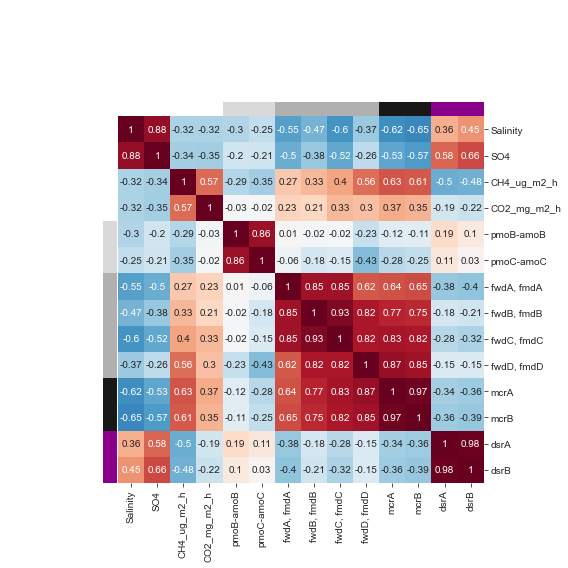

In [104]:
cm = sns.clustermap(corr_mat, row_cluster=False, annot=True, col_cluster=False,
                   row_colors = RAST_colors, col_colors = RAST_colors, figsize = (8,8), cmap = "RdBu_r",
                   vmax = 1, vmin = -1)
cm.cax.set_visible(False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)                                # rotate ticks

In [105]:
#cm.savefig("../figs/Rast_genes_ALL_HeatM.pdf")
#cm.savefig("../figs/Rast_genes_DELTA_HeatM.pdf")
# With Cliff log10 update
#cm.savefig("../figs/Rast_genes_ALL_HeatM_log10.pdf")
#cm.savefig("../figs/Rast_genes_DELTA_HeatM_log10.pdf")

# 4) TS Clustermap

### a) import data and colors

In [59]:
# Import data
TS_Guild_counts = pd.read_csv('../data/shotgun/TreeSapp_v0.5_parsed_tables/TS_cleaned_guild_abund_table.txt', sep = '\t')
TS_Guild_counts['Guild']

# Drop some columns
drop_cols = ['OTU', 'Guild']
TS_Guild_counts = TS_Guild_counts.drop(drop_cols, axis = 1).T      # TS_Guild_counts.columns   # TS_Guild_counts

In [60]:
# aggregate MOB I subbranches
TS_Guild_counts['MOB.I'] = TS_Guild_counts['MOB.Ia'] + TS_Guild_counts['MOB.Ib'] + TS_Guild_counts['MOB.Ic']

# Cliff - calculate totals
TS_Guild_counts['pmoA.tot'] = TS_Guild_counts['MOB.I'] + TS_Guild_counts['MOB.IIa'] + TS_Guild_counts['MOB.IIb'] + TS_Guild_counts['MOB.III']
TS_Guild_counts['amoA.tot'] = TS_Guild_counts['amoA.AOA'] + TS_Guild_counts['amoA.AOB'] + TS_Guild_counts['AmoA.Ic']

# reduce guild list - original for Figure S5!
#keep_TS_guilds = ['mcr.H2', 'mcr.Ac', 'MOB.I','MOB.IIa','amoA.AOA', 'amoA.AOB','NOB.nxr',
#               'DsrAB.red', 'HydA']

# Cliff - keep more lists to calc tot pmoA and tot amoA
keep_TS_guilds = ['mcr.H2', 'mcr.Ac', 'MOB.I','MOB.IIa','MOB.IIb','MOB.III', 'pmoA.tot', 'amoA.tot', 'amoA.AOA','amoA.AOB','NOB.nxr',
               'DsrAB.red', 'HydA']

# keep only minimal gene list
TS_Guild_counts = TS_Guild_counts[keep_TS_guilds]       # TS_Guild_counts.head()

In [61]:
# Log2 n+1 transform data
TS_Guild_counts2 = TS_Guild_counts.replace(0,2)                         # For log n+1, replace 0 with 2
TS_Guild_countsLog2 = np.log2(TS_Guild_counts2)                         # Get log2 data 
TS_Guild_countsLog2 = TS_Guild_countsLog2.replace(1,0)                  # Make 0 again 0


TS_Guild_abund = TS_Guild_countsLog2
#TS_Guild_abund['Sample'] = TS_Guild_abund.index

In [62]:
TS_Guild_abund.columns

Index(['mcr.H2', 'mcr.Ac', 'MOB.I', 'MOB.IIa', 'MOB.IIb', 'MOB.III',
       'pmoA.tot', 'amoA.tot', 'amoA.AOA', 'amoA.AOB', 'NOB.nxr', 'DsrAB.red',
       'HydA'],
      dtype='object')

In [63]:
# Get colors
TS_guild_colors = pd.read_csv("../data/colors/TreeSAPP_Guild_color_palette2.txt", sep='\t')
TS_guild_colors#.head()

,Guild,Index,color
0,mcr.H2,1,#CD4F39
1,mcr.Ac,2,#8B3626
2,MOB.Ia,3,#63B8FF
3,MOB.Ib,4,#00D0FF
4,MOB.Ic,5,#00E4EA
5,MOB.IIb,6,#4F94CD
6,MOB.IIa,7,#36648B
7,MOB.III,8,#8986DC
8,pxmA,9,#9B6AC0
9,emoA,10,#836FFF


# Match colors & extract vector


In [64]:
TS_guild_keep = pd.DataFrame(TS_Guild_abund.columns)
TS_guild_keep.columns = ['Guild']
TS_guild_keep

,Guild
0,mcr.H2
1,mcr.Ac
2,MOB.I
3,MOB.IIa
4,MOB.IIb
5,MOB.III
6,pmoA.tot
7,amoA.tot
8,amoA.AOA
9,amoA.AOB


In [65]:
TS_guild_key = pd.merge(TS_guild_keep, TS_guild_colors, on = 'Guild', how = 'left')
TS_guild_colors = TS_guild_key['color']
TS_guild_colors

0     #CD4F39
1     #8B3626
2         NaN
3     #36648B
4     #4F94CD
5     #8986DC
6         NaN
7         NaN
8     #7CFC00
9     #00CD00
10    #008B00
11    #8B008B
12    #CD6600
Name: color, dtype: object

In [66]:
#gene_colors = pd.Series(CH4_S_genes_min['color'])
# TS_guild_colors = pd.Series()
chem_colors = pd.Series(['#ffffff', '#ffffff','#ffffff','#ffffff'])
TS_colors = pd.Series(chem_colors.append(TS_guild_colors))
TS_colors = TS_colors.tolist()
TS_colors
#RAST_colors
#chem_colors

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#CD4F39',
 '#8B3626',
 nan,
 '#36648B',
 '#4F94CD',
 '#8986DC',
 nan,
 nan,
 '#7CFC00',
 '#00CD00',
 '#008B00',
 '#8B008B',
 '#CD6600']

In [67]:
TS_colors

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#CD4F39',
 '#8B3626',
 nan,
 '#36648B',
 '#4F94CD',
 '#8986DC',
 nan,
 nan,
 '#7CFC00',
 '#00CD00',
 '#008B00',
 '#8B008B',
 '#CD6600']

In [68]:
TS_colors[6] = '#63B8FF'

In [69]:
TS_colors

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#CD4F39',
 '#8B3626',
 '#63B8FF',
 '#36648B',
 '#4F94CD',
 '#8986DC',
 nan,
 nan,
 '#7CFC00',
 '#00CD00',
 '#008B00',
 '#8B008B',
 '#CD6600']

### b) make clustermap

In [70]:
TS_Guild_abund['Sample'] = TS_Guild_abund.index
TS_Guild_abund.columns

Index(['mcr.H2', 'mcr.Ac', 'MOB.I', 'MOB.IIa', 'MOB.IIb', 'MOB.III',
       'pmoA.tot', 'amoA.tot', 'amoA.AOA', 'amoA.AOB', 'NOB.nxr', 'DsrAB.red',
       'HydA', 'Sample'],
      dtype='object')

In [106]:
# merge with metadata
CH4s_gene_meta_data = pd.merge(Sal_CH4_data_only, TS_Guild_abund, on = 'Sample', how = 'inner')
#CH4s_gene_meta_data = CH4s_gene_meta_data.set_index('Sample')

In [72]:
# To rerun with Delta only, run this then rerun below.
# Get any dataset of Delta
Delta_sites = pd.read_csv('../data/meta/SF_sal_meta_FIX3.5.txt', sep='\t')
Delta_sites = Delta_sites[(Delta_sites['SALTgroup'] == 'FW') | (Delta_sites['SALTgroup'] == 'Oligo')]
Delta_sites.shape
Delta_sites.Sample

# Filter the data frame by those sample IDs
CH4s_gene_meta_data = CH4s_gene_meta_data[CH4s_gene_meta_data['Sample'].isin(Delta_sites.Sample)]
CH4s_gene_meta_data.shape

(62, 18)

In [107]:
# get corr matrix
corr_mat = CH4s_gene_meta_data.corr().round(2)
#corr_mat['gene'] = corr_mat.index
corr_mat

,Salinity,SO4,CH4_ug_m2_h,CO2_mg_m2_h,mcr.H2,mcr.Ac,MOB.I,MOB.IIa,MOB.IIb,MOB.III,pmoA.tot,amoA.tot,amoA.AOA,amoA.AOB,NOB.nxr,DsrAB.red,HydA
Salinity,1.00,0.89,-0.32,-0.33,-0.59,-0.50,-0.54,-0.61,-0.21,-0.28,-0.63,-0.11,-0.03,-0.00,-0.26,0.52,-0.11
SO4,0.89,1.00,-0.34,-0.35,-0.43,-0.49,-0.35,-0.44,-0.17,-0.28,-0.44,-0.32,-0.27,0.02,-0.44,0.57,0.06
CH4_ug_m2_h,-0.32,-0.34,1.00,0.57,0.58,0.61,0.13,0.03,0.17,-0.13,0.09,0.06,0.05,-0.35,-0.01,-0.25,0.46
CO2_mg_m2_h,-0.33,-0.35,0.57,1.00,0.40,0.30,0.26,0.30,0.25,-0.04,0.30,-0.01,-0.01,-0.17,0.06,-0.15,0.27
mcr.H2,-0.59,-0.43,0.58,0.40,1.00,0.81,0.43,0.36,0.19,-0.09,0.40,-0.28,-0.26,-0.44,-0.27,-0.16,0.66
mcr.Ac,-0.50,-0.49,0.61,0.30,0.81,1.00,0.17,0.17,0.11,-0.11,0.16,-0.04,-0.01,-0.48,-0.15,-0.25,0.45
MOB.I,-0.54,-0.35,0.13,0.26,0.43,0.17,1.00,0.65,0.13,0.07,0.90,-0.15,-0.26,0.12,-0.02,-0.04,0.39
MOB.IIa,-0.61,-0.44,0.03,0.30,0.36,0.17,0.65,1.00,0.20,0.19,0.88,-0.03,-0.11,0.14,0.13,-0.21,0.14
MOB.IIb,-0.21,-0.17,0.17,0.25,0.19,0.11,0.13,0.20,1.00,0.18,0.20,-0.05,-0.13,0.04,-0.05,-0.09,0.07
MOB.III,-0.28,-0.28,-0.13,-0.04,-0.09,-0.11,0.07,0.19,0.18,1.00,0.20,0.23,0.18,0.31,0.30,-0.23,-0.30


In [108]:
# Save exact data files for revision figure!
#CH4s_gene_meta_data.to_csv('../data/shotgun/cor_input_data_All.csv')
CH4s_gene_meta_data.to_csv('../data/shotgun/cor_input_data_All_log10.csv')

In [109]:
# And with Delta only
#CH4s_gene_meta_data.to_csv('../data/shotgun/cor_input_data_Delta.csv')
CH4s_gene_meta_data.to_csv('../data/shotgun/cor_input_data_Delta_log10.csv')

In [110]:
TS_colors[12] = 'red'

In [111]:
TS_colors

['#ffffff',
 '#ffffff',
 '#ffffff',
 '#ffffff',
 '#CD4F39',
 '#8B3626',
 '#63B8FF',
 '#36648B',
 '#4F94CD',
 '#8986DC',
 nan,
 nan,
 'red',
 '#00CD00',
 '#008B00',
 '#8B008B',
 '#CD6600']

In [112]:
cm = sns.clustermap(corr_mat, row_cluster=False, annot=True, col_cluster=False,
                   row_colors = TS_colors, col_colors = TS_colors, figsize = (8,8), cmap = "RdBu_r",
                   vmax = 1, vmin = -1)
cm.cax.set_visible(False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)                                # rotate ticks

ValueError: Invalid RGBA argument: '#'

<Figure size 576x576 with 0 Axes>

In [158]:
#cm.savefig("../figs/TS_guilds_ALL_HeatM_log10.pdf")
#cm.savefig("../figs/TS_guilds_DELTA_HeatM_log10.pdf")

# 5) 16S Clustermap

### a) import data and colors

In [79]:
Guild_counts = pd.read_csv('../guild_analysis/Silva_OTU_Guild_abundT_counts.txt', sep='\t')#, index_col=0)      # RAST_KO_ordered133_R2_F200_DESeq2_nrm.txt

In [80]:
# Log2 n+1 transform data
Guild_counts2 = Guild_counts.replace(0,2)                         # For log n+1, replace 0 with 2
Guild_countsLog2 = np.log2(Guild_counts2)                         # Get log2 data 
Guild_countsLog2 = Guild_countsLog2.replace(1,0)                  # Make 0 again 0
# Guild_countsLog2

In [81]:
# To Filter only delta samples, or other
Guild_countsLog2["Sample"] = Guild_countsLog2.index               # Get sample column from index
Guild_abund = Guild_countsLog2
# Guild_countsLog2

# Guild_abund = pd.merge(CH4_flux_df, Guild_countsLog2, on='Sample')    # Merge Env var with KO abundance by Samp.
# Guild_abund = Guild_abund.set_index('Sample')
#env_var_df# 
list(Guild_abund.columns) 

['CH4_mix',
 'CH4_H2',
 'CH4_ac',
 'CH4_me',
 'MOB_I',
 'MOB_II',
 'MOB_IIa',
 'ANME',
 'AOA',
 'AOB',
 'NOB',
 'Anamx',
 'SOxB',
 'SRB_syn',
 'SRB',
 'FeOB',
 'FeRB',
 'Methanogen',
 'Methanotroph',
 'Methanogen_Troph',
 'AOA_NOB',
 'AOB_NOB',
 'AO_NOB',
 'Sample']

In [82]:
#Guild_abund.drop
Guild_abund = Guild_abund.iloc[:,0:17]                               # drops ratios
#Guild_abund = Guild_abund.drop(['MeOB','SOxB', 'FeRB', 'Anamx'], axis =1)
#Guild_abund = Guild_abund.drop(['MeOB','SOxB', 'Anamx', 'Methanogen'], axis =1)
#Guild_abund['Sample'] = Guild_abund.index
Guild_abund.head()

,CH4_mix,CH4_H2,CH4_ac,CH4_me,MOB_I,MOB_II,MOB_IIa,ANME,AOA,AOB,NOB,Anamx,SOxB,SRB_syn,SRB,FeOB,FeRB
Sandmound_TuleA_D1,7.898290,9.616519,7.698981,5.266022,13.541215,14.478396,13.241010,0.0,14.594697,15.581171,15.375852,0.0,10.862957,13.658339,15.733831,11.415769,12.306037
Sandmound_TuleA_D2,8.191184,10.481576,8.864374,6.441162,13.387935,14.320467,13.472581,0.0,14.421561,15.536319,15.909879,0.0,10.906543,14.611087,16.355547,12.296880,12.166606
Sandmound_TuleB_D1,0.000000,0.000000,0.000000,0.000000,13.878202,11.790739,11.375701,0.0,13.598094,14.835133,14.920022,0.0,13.697629,10.790739,17.420095,12.375701,13.250170
Sandmound_TuleB_D2,8.862499,10.540571,7.955609,6.762964,14.027071,14.496705,13.601267,0.0,14.755700,15.548533,16.116741,0.0,11.584965,14.964737,16.806382,12.912711,12.952788
Sandmound_TuleC_D1,7.344863,8.859436,5.859436,3.537508,12.986657,14.314763,13.047283,0.0,14.827527,15.855203,15.354491,0.0,10.912547,13.323777,15.592790,10.877358,12.206393


In [83]:
list(Guild_abund.columns)

['CH4_mix',
 'CH4_H2',
 'CH4_ac',
 'CH4_me',
 'MOB_I',
 'MOB_II',
 'MOB_IIa',
 'ANME',
 'AOA',
 'AOB',
 'NOB',
 'Anamx',
 'SOxB',
 'SRB_syn',
 'SRB',
 'FeOB',
 'FeRB']

In [84]:
# Reorder
Guild_abund = Guild_abund.reindex(columns=['CH4_mix','CH4_me','CH4_H2','CH4_ac','MOB_I','MOB_II','MOB_IIa','ANME','AOA','AOB','NOB',
                                          'Anamx','SOxB','SRB_syn','SRB','FeOB','FeRB'])

In [85]:
# Get guild colors 
Guild_colors = pd.read_csv('../data/colors/Guild_color_palette_CB.txt', sep ='\t') # sp error in name, may be used elsewhere though
list(Guild_colors.columns)
#Guild_colors['var'] = Guild_colors['Guild']

# Match colors & extract vector
#guild_keep = pd.DataFrame(Guild_abund.columns)
#guild_keep.columns = ['Guild']
#guild_key = pd.merge(guild_keep, Guild_colors, on = 'Guild', how = 'left')
#guild_key
#guild_colors = guild_key['color']
#guild_colors
# Guild_colors = pd.merge

#Guild_colors#.head()

['Guild', 'Index', 'color']

### b) make clustermap

In [86]:
# keep only minimal gene list
# keep_genes = ['pmoB-amoB', 'pmoC-amoC', 'fwdA, fmdA', 'fwdB, fmdB', 'fwdC, fmdC','fwdD, fmdD', 'mcrA', 'mcrB','dsrA','dsrB']
# CH4_S_genes_min = CH4_S_genes[CH4_S_genes['gene'].isin(keep_genes)]

In [87]:
# Format color list to incl biogeochemical vars (4)
# gene_colors = pd.Series(CH4_S_genes_min['color'])
#chem_colors = pd.Series(['#ffffff', '#ffffff','#ffffff','#ffffff'])
#guild16s_colors = pd.Series(chem_colors.append(guild_colors))         # guild colors from above 
#guild16s_colors = guild16s_colors.tolist()
guild16s_colors = Guild_colors['color']
guild16s_colors

...1      white
...2      white
...3      white
...4      white
...5    #FFFF99
...6    #FDC086
1       #CD4F39
2       #8B3626
3       #63B8FF
4       #4F94CD
5       #36648B
6       #836FFF
7       #7CFC00
8       #00CD00
9       #008B00
10      #00FF7F
11      #CD69C9
12      #CD2990
13      #8B008B
14      #CD6600
15      #8B4513
Name: color, dtype: object

In [88]:
guild16s_colors = guild16s_colors.tolist()

In [89]:
guild16s_colors

['white',
 'white',
 'white',
 'white',
 '#FFFF99',
 '#FDC086',
 '#CD4F39',
 '#8B3626',
 '#63B8FF',
 '#4F94CD',
 '#36648B',
 '#836FFF',
 '#7CFC00',
 '#00CD00',
 '#008B00',
 '#00FF7F',
 '#CD69C9',
 '#CD2990',
 '#8B008B',
 '#CD6600',
 '#8B4513']

In [113]:
# merge with metadata
Guild_abund['Sample'] = Guild_abund.index
CH4s_guild_meta_data = pd.merge(Sal_CH4_data_only, Guild_abund, on = 'Sample', how = 'inner')
#CH4s_gene_meta_data = CH4s_gene_meta_data.set_index('Sample')

In [114]:
CH4s_guild_meta_data.shape

(168, 22)

In [118]:
# To rerun with Delta only, run this then rerun below.
# Get any dataset of Delta (e.g. taxonomic correlations)
Delta_sites = pd.read_csv('../data/meta/SF_sal_meta_FIX3.5.txt', sep='\t')
Delta_sites = Delta_sites[(Delta_sites['SALTgroup'] == 'FW') | (Delta_sites['SALTgroup'] == 'Oligo')]
Delta_sites.shape
Delta_sites.Sample

# Filter the data frame by those sample IDs
CH4s_guild_meta_data = CH4s_guild_meta_data[CH4s_guild_meta_data['Sample'].isin(Delta_sites.Sample)]
CH4s_guild_meta_data.shape

(73, 22)

In [119]:
# get corr matrix
corr_mat = CH4s_guild_meta_data.corr().round(2)
#corr_mat['gene'] = corr_mat.index
corr_mat

,Salinity,SO4,CH4_ug_m2_h,CO2_mg_m2_h,CH4_mix,CH4_me,CH4_H2,CH4_ac,MOB_I,MOB_II,...,ANME,AOA,AOB,NOB,Anamx,SOxB,SRB_syn,SRB,FeOB,FeRB
Salinity,1.00,0.50,0.26,-0.24,-0.12,-0.17,-0.23,-0.26,-0.41,0.34,...,0.65,0.63,-0.16,0.36,-0.17,-0.21,-0.37,-0.30,-0.07,0.08
SO4,0.50,1.00,0.07,-0.25,0.25,0.19,0.22,0.16,0.09,-0.01,...,0.23,0.18,-0.28,-0.01,-0.08,0.26,0.10,0.25,0.12,0.23
CH4_ug_m2_h,0.26,0.07,1.00,0.62,0.41,0.48,0.40,0.52,-0.30,-0.10,...,0.65,-0.09,-0.65,-0.41,0.08,0.37,0.27,-0.15,0.16,-0.28
CO2_mg_m2_h,-0.24,-0.25,0.62,1.00,0.32,0.38,0.36,0.37,0.16,-0.39,...,0.03,-0.48,-0.25,-0.48,0.15,0.39,0.38,-0.04,0.36,-0.03
CH4_mix,-0.12,0.25,0.41,0.32,1.00,0.88,0.89,0.72,0.33,-0.40,...,0.08,-0.52,-0.56,-0.64,0.12,0.66,0.81,0.11,0.45,0.14
CH4_me,-0.17,0.19,0.48,0.38,0.88,1.00,0.91,0.81,0.28,-0.50,...,0.14,-0.57,-0.65,-0.74,0.12,0.73,0.88,0.19,0.47,0.07
CH4_H2,-0.23,0.22,0.40,0.36,0.89,0.91,1.00,0.87,0.33,-0.54,...,0.06,-0.61,-0.59,-0.75,0.06,0.64,0.91,0.23,0.50,0.12
CH4_ac,-0.26,0.16,0.52,0.37,0.72,0.81,0.87,1.00,0.07,-0.45,...,0.21,-0.49,-0.71,-0.76,0.01,0.54,0.77,0.20,0.27,-0.15
MOB_I,-0.41,0.09,-0.30,0.16,0.33,0.28,0.33,0.07,1.00,-0.56,...,-0.71,-0.62,0.08,-0.30,0.14,0.41,0.50,0.31,0.63,0.65
MOB_II,0.34,-0.01,-0.10,-0.39,-0.40,-0.50,-0.54,-0.45,-0.56,1.00,...,0.29,0.83,0.37,0.77,-0.09,-0.61,-0.64,-0.26,-0.60,-0.32


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

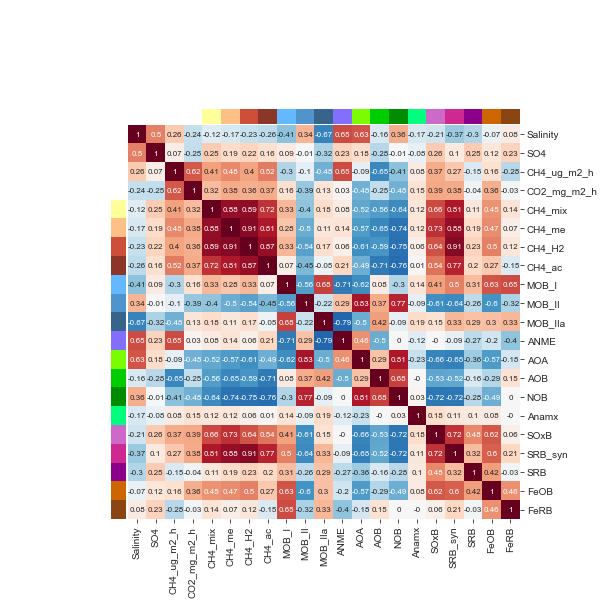

In [120]:
cm = sns.clustermap(corr_mat, row_cluster=False, annot=True, annot_kws={"size": 8}, col_cluster=False,
                   row_colors = guild16s_colors, col_colors = guild16s_colors, figsize = (8.5,8.5), cmap = "RdBu_r",
                   vmax = 1, vmin = -1)
cm.cax.set_visible(False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)                                # rotate ticks

In [121]:
#cm.savefig("../figs/16S_guilds_ALL_HeatM_log10.pdf")
#cm.savefig("../figs/16S_guilds_DELTA_HeatM_log10.pdf")

# Chem - chem corrs


In [ ]:
#### Select OLIGO only sites at own risk !!
# can just comment this line out:
#Sal_meta=Oligo_FW_sites

#### iii) Select Env. Chem variables
- ignores some features like soil metals
- sets NA to 0.1 to fill missing porewater data (below detection)

In [78]:
Sal_meta.head()
Sal_meta.columns

Index(['EWsiteHyd_index', 'Sample', 'MG_name', 'Index', 'Location', 'Pl_Sp',
       'EWcoastGroup', 'SALTgroup', 'LU', 'Depth', 'EW.no', 'iTag_name.x',
       'Site_indx', 'Salinity.x', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',
       'CO2_soilC_mg_g_d', 'CH4_ug_m2_h', 'CH4_CO2', 'CH4_soilC_ug_g_d', 'pH',
       'Cl', 'SO4', 'Corg_LOI', 'C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'C_g_m2', 'N_g_m2', 'P_g_m2',
       'Fe', 'Mn', 'Cu', 'Zn', 'Salinity.y', 'CO2_mg_m2_h.1', 'CH4_ug_m2_h.1',
       'Cl_pw', 'SO4_pw', 'DOC_mg_L', 'NO2_pw', 'NO3_pw', 'NH3_pw', 'PO4_pw',
       'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw', 'Ca_pw', 'Sr_pw', 'Mg_pw',
       'Na_pw', 'K_pw', 'Al_pw', 'Si_pw', 'Br_pw', 'F_pw', 'Salinity'],
      dtype='object')

In [85]:
## CUT Down Env. Data
env_chem_List = ['Salinity', 'Bulk_dens', 'H2O_FPS', 'CO2_mg_m2_h',                       # with log DATA, delete 'logCH4' now is logged, except for LIN vars
       'CH4_ug_m2_h', 'CH4_CO2', 'pH',            # Drop cations, corr w. Sal: 'Ca_pw', 'Sr_pw','Mg_pw', 'Na_pw', 'K_pw', 'Al_pw', 'Si_pw', 'Br_pw', 'F_pw', 'logCH4']
       'Cl', 'SO4','C', 'N', 'P', 'NO3_N', 'NH4_N', 'Olsen_P',               # Drop soil metals for now, half NA: 'Fe', 'Mn', 'Cu', 'Zn']
       'CN', 'CP', 'NP', 'NP_ext', 'NO3_NH4', 'Fe', 'Mn', 'Cu', 'Zn',               # Drop redundant cols for PW: 'Salinity.x.1', 'CO2_mg_m2_h.1','CH4_ug_m2_h.1'
       'DOC_mg_L','Cl_pw', 'SO4_pw', 'NO2_pw', 'NO3_pw','NH3_pw',                         # Much more DELETED here, see earlier versions... # Sal_meta.columns # Env_chem.head()  
       'PO4_pw', 'Fe_pw', 'Mn_pw', 'Co_pw', 'Cu_pw', 'Zn_pw'] 
              
# ABSTRACT Env_chem
Env_chem = Sal_meta[env_chem_List]  # Get columns
Env_chem.fillna(0.1, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals

## ReINDEX Env. chem, MUST BE by Sample
Sample= Sal_meta['Sample'] 
Env_chem = Env_chem.set_index(Sample,0) 
del Env_chem.index.name        

# Drop bad porewater data from above
drop_vars = ['NO2_pw', 'NO3_pw','NH3_pw', 'PO4_pw']              # inorg N samps ruined, PO4 mostly 0/NA due to IC method
Env_chem.drop(drop_vars, axis = 1, inplace=True)

# Drop more non-sense variables 

#### iv) log transform data
#- includes log n+1 for vars with negative values (like CH4 flux!)

# Log10 transform data set
Env_chem_log = np.log10(Env_chem)
# Env_chem_log.head()

# Get log(n+1 data) for select vars
log_n1_cols = ['CH4_ug_m2_h', 'CH4_CO2']#, 'CH4_soilC_ug_g_d']
log_n1_data = np.log(Env_chem[log_n1_cols] + 1)
# log_n1_data.head()

# Replace log N + 1 data
Env_chem_log['CH4_ug_m2_h'] =  log_n1_data['CH4_ug_m2_h']
Env_chem_log['CH4_CO2'] =  log_n1_data['CH4_CO2']
#Env_chem_log['CH4_soilC_ug_g_d'] =  log_n1_data['CH4_soilC_ug_g_d']

# Fill NA in porewater
#Env_chem.fillna(0.1, inplace = True)  # Fill NAs w 0, for porewater ND - careful with soil metals


#Env_chem_log.head()

In [102]:
Env_chem_log.head()
#Env_chem_log.shape

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CH4_ug_m2_h,CH4_CO2,pH,Cl,SO4,C,...,Cu,Zn,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Sandmound_TuleA_D1,-0.226634,-0.576150,1.931627,0.170561,1.699839,0.263921,0.789581,1.142702,1.713491,1.173186,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
Sandmound_TuleA_D2,-0.226634,-0.561732,1.927049,0.170561,1.699839,0.263921,0.771587,1.030195,1.927370,1.175512,...,1.812913,1.954243,0.994009,2.425115,0.536053,2.789143,2.434633,-0.366532,0.506505,-1.0
Sandmound_TuleB_D1,-0.219956,-0.605605,1.902172,0.620485,-0.332596,-0.006803,0.797268,1.149835,1.599883,1.180413,...,-1.000000,-1.000000,1.070776,2.337650,-0.057744,2.795477,3.070042,-0.408935,0.130334,-1.0
Sandmound_TuleB_D2,-0.219956,-0.587656,1.896442,0.620485,-0.332596,-0.006803,0.767156,1.123852,1.609594,1.133219,...,1.812913,1.973128,1.070776,2.337650,-0.057744,2.795477,3.070042,-0.408935,0.130334,-1.0
Sandmound_TuleC_D1,-0.246824,-0.619023,1.925604,0.246613,0.655385,0.051144,0.796574,1.116608,1.598791,1.216166,...,-1.000000,-1.000000,1.250420,2.743198,1.238397,3.579373,3.481973,0.315970,0.678518,-1.0


In [87]:
# get corr matrix
log_corr = Env_chem_log.corr().round(2)
#corr_mat['gene'] = corr_mat.index
log_corr

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CH4_ug_m2_h,CH4_CO2,pH,Cl,SO4,C,...,Cu,Zn,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Salinity,1.00,0.47,0.04,-0.37,-0.37,-0.27,0.08,0.99,0.90,-0.71,...,0.00,0.03,-0.21,0.60,0.85,-0.25,0.32,0.62,0.89,0.77
Bulk_dens,0.47,1.00,-0.38,-0.46,-0.13,0.13,0.21,0.46,0.24,-0.70,...,0.13,0.14,-0.08,0.31,0.28,-0.02,0.25,0.33,0.37,0.16
H2O_FPS,0.04,-0.38,1.00,-0.23,-0.41,-0.43,-0.27,0.10,0.30,0.05,...,-0.32,-0.31,-0.34,-0.08,0.10,-0.10,-0.04,-0.05,0.05,0.17
CO2_mg_m2_h,-0.37,-0.46,-0.23,1.00,0.58,0.33,-0.23,-0.38,-0.40,0.63,...,-0.01,-0.03,0.38,-0.22,-0.34,0.09,-0.10,-0.17,-0.39,-0.30
CH4_ug_m2_h,-0.37,-0.13,-0.41,0.58,1.00,0.90,0.18,-0.37,-0.40,0.53,...,-0.02,-0.04,0.65,-0.17,-0.40,0.22,-0.14,-0.10,-0.37,-0.42
CH4_CO2,-0.27,0.13,-0.43,0.33,0.90,1.00,0.24,-0.28,-0.35,0.36,...,-0.02,-0.03,0.64,-0.12,-0.38,0.27,-0.11,-0.02,-0.28,-0.43
pH,0.08,0.21,-0.27,-0.23,0.18,0.24,1.00,0.06,0.07,-0.16,...,-0.18,-0.18,0.24,0.15,0.01,-0.08,0.10,-0.04,0.05,0.00
Cl,0.99,0.46,0.10,-0.38,-0.37,-0.28,0.06,1.00,0.91,-0.71,...,-0.01,0.02,-0.22,0.60,0.85,-0.25,0.33,0.62,0.88,0.77
SO4,0.90,0.24,0.30,-0.40,-0.40,-0.35,0.07,0.91,1.00,-0.61,...,-0.09,-0.06,-0.29,0.54,0.82,-0.27,0.27,0.56,0.83,0.79
C,-0.71,-0.70,0.05,0.63,0.53,0.36,-0.16,-0.71,-0.61,1.00,...,-0.09,-0.12,0.52,-0.50,-0.64,0.31,-0.27,-0.42,-0.66,-0.59


In [96]:
#log_corr.to_csv("ALL_sites_chem_log_corr_py.txt", sep = '\t')

In [98]:
# get corr matrix
all_corr = Env_chem.corr().round(2)
#corr_mat['gene'] = corr_mat.index
all_corr

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CH4_ug_m2_h,CH4_CO2,pH,Cl,SO4,C,...,Cu,Zn,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Salinity,1.00,0.28,0.08,-0.29,-0.25,-0.30,-0.19,0.97,0.93,-0.52,...,0.02,0.15,-0.34,0.85,0.98,-0.01,-0.05,0.65,0.95,0.33
Bulk_dens,0.28,1.00,-0.54,-0.37,0.22,0.26,0.30,0.26,0.21,-0.70,...,0.20,0.25,0.06,0.34,0.29,-0.05,-0.18,0.17,0.31,0.20
H2O_FPS,0.08,-0.54,1.00,-0.27,-0.39,-0.41,-0.27,0.13,0.22,0.06,...,-0.25,-0.22,-0.33,0.01,0.10,0.13,0.06,0.01,0.05,-0.03
CO2_mg_m2_h,-0.29,-0.37,-0.27,1.00,0.49,0.32,-0.15,-0.30,-0.35,0.58,...,-0.07,-0.15,0.33,-0.29,-0.31,-0.09,-0.05,-0.12,-0.30,-0.14
CH4_ug_m2_h,-0.25,0.22,-0.39,0.49,1.00,0.88,0.06,-0.25,-0.28,0.17,...,-0.05,-0.11,0.52,-0.24,-0.25,-0.02,-0.10,-0.09,-0.22,-0.10
CH4_CO2,-0.30,0.26,-0.41,0.32,0.88,1.00,0.17,-0.29,-0.29,0.19,...,-0.07,-0.13,0.59,-0.28,-0.29,0.00,-0.08,-0.13,-0.26,-0.13
pH,-0.19,0.30,-0.27,-0.15,0.06,0.17,1.00,-0.21,-0.15,-0.12,...,-0.24,-0.19,0.24,-0.12,-0.21,-0.22,0.07,-0.21,-0.20,0.08
Cl,0.97,0.26,0.13,-0.30,-0.25,-0.29,-0.21,1.00,0.96,-0.51,...,-0.01,0.11,-0.34,0.88,0.96,0.03,-0.04,0.61,0.95,0.30
SO4,0.93,0.21,0.22,-0.35,-0.28,-0.29,-0.15,0.96,1.00,-0.48,...,-0.02,0.12,-0.33,0.84,0.92,0.02,-0.02,0.56,0.91,0.26
C,-0.52,-0.70,0.06,0.58,0.17,0.19,-0.12,-0.51,-0.48,1.00,...,-0.17,-0.31,0.37,-0.53,-0.50,0.02,-0.01,-0.29,-0.47,-0.24


### Delta only sites

In [90]:
Delta_sites = Oligo_FW_sites['Sample']

In [94]:
# 
log_Delta = Env_chem_log[Env_chem_log.index.isin(Delta_sites)]

In [95]:
# get corr matrix
Delta_corr = log_Delta.corr().round(2)
#corr_mat['gene'] = corr_mat.index
Delta_corr

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CH4_ug_m2_h,CH4_CO2,pH,Cl,SO4,C,...,Cu,Zn,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Salinity,1.00,0.62,-0.39,-0.25,0.25,0.41,0.38,0.96,0.50,-0.55,...,-0.02,0.01,0.56,0.62,0.26,0.14,0.22,0.44,0.62,-0.01
Bulk_dens,0.62,1.00,-0.58,-0.30,0.13,0.36,0.34,0.62,-0.04,-0.76,...,0.10,0.11,0.28,0.30,0.07,0.28,0.46,0.36,0.22,-0.24
H2O_FPS,-0.39,-0.58,1.00,-0.22,-0.57,-0.57,-0.43,-0.30,0.28,0.21,...,-0.30,-0.29,-0.42,-0.31,-0.21,-0.06,-0.18,-0.28,-0.15,0.04
CO2_mg_m2_h,-0.25,-0.30,-0.22,1.00,0.62,0.39,-0.16,-0.26,-0.24,0.47,...,-0.01,-0.02,0.14,-0.00,-0.08,-0.09,-0.12,-0.03,-0.16,0.02
CH4_ug_m2_h,0.25,0.13,-0.57,0.62,1.00,0.91,0.35,0.21,0.07,0.34,...,-0.03,-0.03,0.58,0.26,0.12,-0.09,-0.17,0.34,0.16,0.06
CH4_CO2,0.41,0.36,-0.57,0.39,0.91,1.00,0.42,0.38,0.14,0.14,...,-0.02,-0.02,0.65,0.34,0.10,0.03,-0.04,0.45,0.25,-0.04
pH,0.38,0.34,-0.43,-0.16,0.35,0.42,1.00,0.31,0.29,0.07,...,-0.14,-0.14,0.50,0.23,0.09,0.06,-0.03,0.27,0.30,-0.02
Cl,0.96,0.62,-0.30,-0.26,0.21,0.38,0.31,1.00,0.54,-0.57,...,0.01,0.03,0.52,0.60,0.23,0.13,0.21,0.44,0.61,0.00
SO4,0.50,-0.04,0.28,-0.24,0.07,0.14,0.29,0.54,1.00,-0.02,...,-0.33,-0.31,0.32,0.34,0.18,0.05,-0.06,0.20,0.44,0.15
C,-0.55,-0.76,0.21,0.47,0.34,0.14,0.07,-0.57,-0.02,1.00,...,-0.12,-0.14,0.13,-0.25,-0.14,-0.19,-0.49,-0.14,-0.21,0.16


In [97]:
Delta_corr.to_csv("DELTA_sites_chem_log_corr_py.txt", sep = '\t')

In [ ]:
# no log 

In [100]:
delta_chem = Env_chem[Env_chem.index.isin(Delta_sites)]
# get corr matrix
deltaNL_corr = delta_chem.corr().round(2)
#corr_mat['gene'] = corr_mat.index
deltaNL_corr

,Salinity,Bulk_dens,H2O_FPS,CO2_mg_m2_h,CH4_ug_m2_h,CH4_CO2,pH,Cl,SO4,C,...,Cu,Zn,DOC_mg_L,Cl_pw,SO4_pw,Fe_pw,Mn_pw,Co_pw,Cu_pw,Zn_pw
Salinity,1.00,0.50,-0.34,-0.15,0.22,0.28,0.25,0.92,0.35,-0.47,...,-0.08,0.05,0.58,0.61,-0.04,-0.18,0.23,0.23,0.39,-0.27
Bulk_dens,0.50,1.00,-0.75,-0.21,0.36,0.45,0.49,0.42,-0.21,-0.72,...,0.12,0.15,0.34,0.20,0.02,-0.02,0.13,0.22,-0.07,-0.30
H2O_FPS,-0.34,-0.75,1.00,-0.23,-0.45,-0.51,-0.43,-0.23,0.28,0.26,...,-0.17,-0.17,-0.34,-0.20,-0.06,0.25,0.02,-0.16,0.05,0.03
CO2_mg_m2_h,-0.15,-0.21,-0.23,1.00,0.53,0.30,-0.21,-0.13,-0.22,0.46,...,-0.05,-0.10,0.12,0.04,-0.08,-0.22,-0.23,0.00,-0.14,0.30
CH4_ug_m2_h,0.22,0.36,-0.45,0.53,1.00,0.87,0.12,0.23,-0.06,-0.06,...,-0.07,-0.08,0.45,0.21,-0.12,-0.14,-0.14,0.24,-0.01,-0.12
CH4_CO2,0.28,0.45,-0.51,0.30,0.87,1.00,0.29,0.25,0.08,-0.08,...,-0.10,-0.11,0.53,0.26,-0.12,-0.16,-0.17,0.22,0.04,-0.16
pH,0.25,0.49,-0.43,-0.21,0.12,0.29,1.00,0.21,0.31,-0.05,...,-0.25,-0.27,0.44,0.11,-0.07,-0.17,-0.30,-0.02,0.19,-0.16
Cl,0.92,0.42,-0.23,-0.13,0.23,0.25,0.21,1.00,0.48,-0.43,...,-0.10,0.04,0.56,0.61,0.01,-0.16,0.22,0.25,0.41,-0.24
SO4,0.35,-0.21,0.28,-0.22,-0.06,0.08,0.31,0.48,1.00,0.21,...,-0.28,-0.23,0.39,0.29,-0.01,-0.12,-0.09,0.08,0.43,-0.10
C,-0.47,-0.72,0.26,0.46,-0.06,-0.08,-0.05,-0.43,0.21,1.00,...,-0.21,-0.30,0.03,-0.15,-0.08,-0.22,-0.43,-0.19,0.13,0.43
